# Importing modules

In [167]:
# Standard libraries
import pandas as pd
import numpy as np
import pickle
import math
import re

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = [12.0, 6.0]
plt.rcParams['figure.dpi'] = 150

# Data processing 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from tensorflow.python import tf2
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# Scores
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Reading data

In [145]:
# Reading data and randomizing it
transactions = pd.read_csv('fraud.csv').sample(frac=1).reset_index(drop=True)
transactions

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,211,CASH_IN,342640.77,C1870098919,4464702.61,4807343.38,C122213904,374042.59,31401.82,0,0
1,351,PAYMENT,5721.06,C644943361,998234.66,992513.60,M1799888286,0.00,0.00,0,0
2,399,PAYMENT,22216.50,C701235596,253786.10,231569.60,M485277503,0.00,0.00,0,0
3,228,CASH_OUT,458069.49,C975119024,350.00,0.00,C999222882,0.00,458069.49,0,0
4,514,PAYMENT,7337.46,C1099954838,123615.37,116277.92,M1254307134,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,371,PAYMENT,42722.19,C276848902,13459.00,0.00,M419293818,0.00,0.00,0,0
6362616,162,CASH_IN,318650.23,C2027067085,21310.00,339960.23,C956684685,1149554.28,830904.04,0,0
6362617,369,PAYMENT,16551.42,C1609260880,154.17,0.00,M329330958,0.00,0.00,0,0
6362618,228,DEBIT,7410.30,C180700172,16084.00,8673.70,C719725141,450041.30,457451.60,0,0


# Cleaning

### Transforming text to snake_case

In [146]:
# transforming column names to snake_case
transactions.columns = snake_case(transactions.columns)

# transforming 'type' column to lowercase
transactions['type'] = transactions['type'].str.lower()

transactions.head()

,step,type,amount,name_orig,oldbalance_orig,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
0,211,cash_in,342640.77,C1870098919,4464702.61,4807343.38,C122213904,374042.59,31401.82,0,0
1,351,payment,5721.06,C644943361,998234.66,992513.60,M1799888286,0.00,0.00,0,0
2,399,payment,22216.50,C701235596,253786.10,231569.60,M485277503,0.00,0.00,0,0
3,228,cash_out,458069.49,C975119024,350.00,0.00,C999222882,0.00,458069.49,0,0
4,514,payment,7337.46,C1099954838,123615.37,116277.92,M1254307134,0.00,0.00,0,0


### NaNs

In [147]:
# Checking that we have no NaN values
transactions.isna().sum().sum()

0

### Dropping unique columns

In [148]:
# Reducing name_orig and name_dest by keeping only the type of account (first character of the column)
transactions['name_orig'] = transactions['name_orig'].apply(lambda x: x[0])
transactions['name_dest'] = transactions['name_dest'].apply(lambda x: x[0])

transactions.head()

,step,type,amount,name_orig,oldbalance_orig,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
0,211,cash_in,342640.77,C,4464702.61,4807343.38,C,374042.59,31401.82,0,0
1,351,payment,5721.06,C,998234.66,992513.60,M,0.00,0.00,0,0
2,399,payment,22216.50,C,253786.10,231569.60,M,0.00,0.00,0,0
3,228,cash_out,458069.49,C,350.00,0.00,C,0.00,458069.49,0,0
4,514,payment,7337.46,C,123615.37,116277.92,M,0.00,0.00,0,0


In [149]:
transactions[transactions['type']=='transfer']

,step,type,amount,name_orig,oldbalance_orig,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
8,236,transfer,165208.33,C,0.0,0.0,C,260994.14,426202.47,0,0
20,400,transfer,318127.55,C,0.0,0.0,C,621604.62,939732.17,0,0
35,16,transfer,83118.60,C,0.0,0.0,C,1163519.46,1246638.06,0,0
42,232,transfer,378446.52,C,0.0,0.0,C,881165.58,1259612.10,0,0
54,253,transfer,1258419.82,C,48485.0,0.0,C,701218.63,1959638.45,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362559,15,transfer,318555.69,C,0.0,0.0,C,5080014.27,5398569.96,0,0
6362568,263,transfer,143890.89,C,0.0,0.0,C,1799319.95,1943210.83,0,0
6362590,181,transfer,222616.39,C,0.0,0.0,C,775415.38,998031.77,0,0
6362599,15,transfer,1869095.74,C,80315.0,0.0,C,0.00,1869095.74,0,0


### Dropping non-useful rows

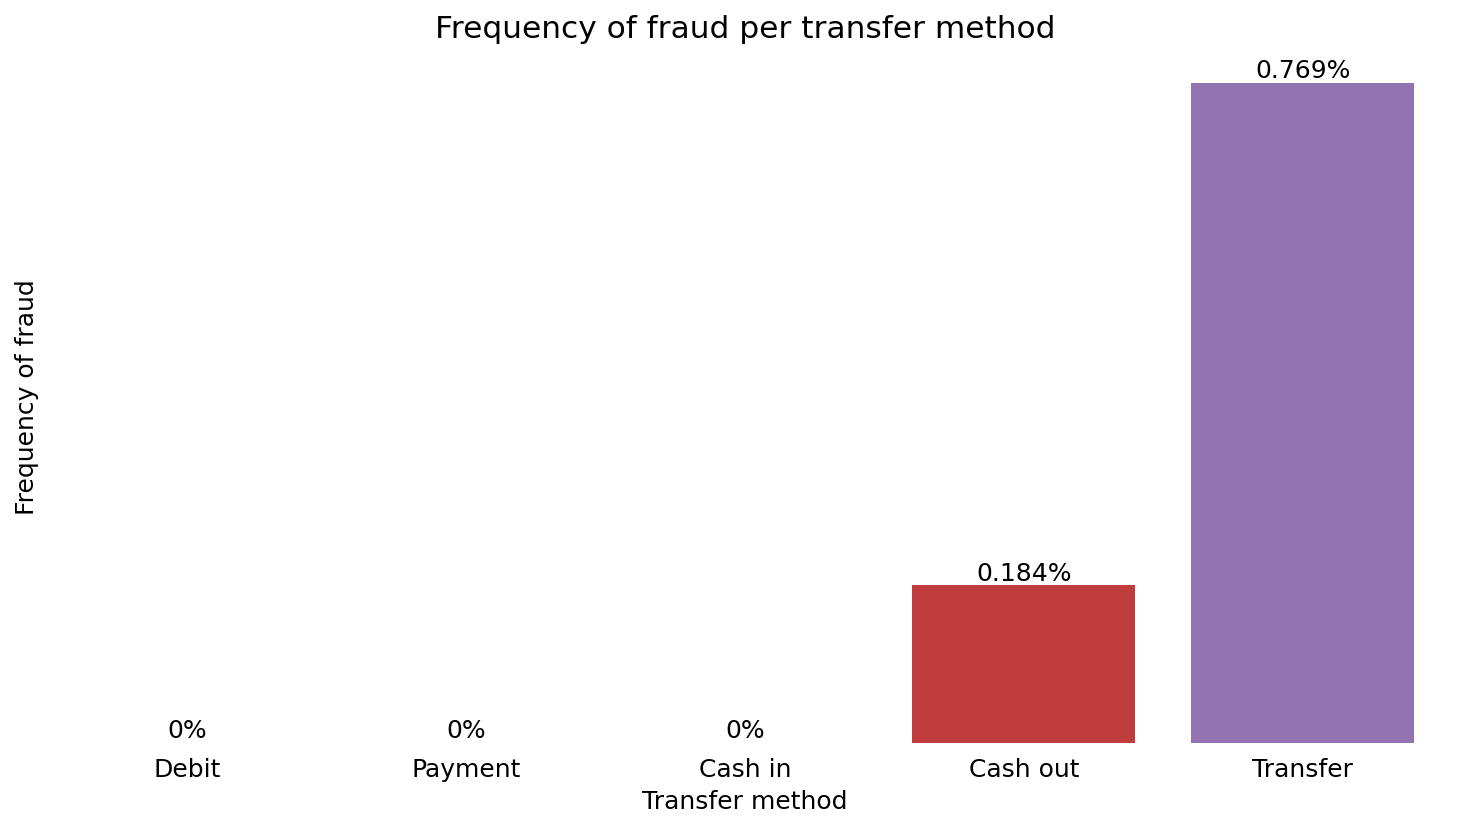

In [150]:
# Plotting the frequency of frauds per transfer method
order = ['debit','payment','cash_in','cash_out','transfer']

ax = sns.barplot(x="type", y=np.where(transactions["is_fraud"],1,0)*100, data=transactions,errorbar=None,order=order)

cute_graph(title = ['Frequency of fraud per transfer method',15],
           xlabel= ['Transfer method',12],
           ylabel = ['Frequency of fraud',12],
          xticklabels = undo_snake_case(order))
plt.show()

We can see that there're only fraudulent transfer in just two methods: cash out and transfer. We will filter out the rest of methods, and when we finally try to predict our test, we will flag as non fraud any transfer with those methods.

In [151]:
transactions = transactions.loc[transactions['type'].isin(['cash_out','transfer'])].copy()

In [152]:
# Checking unique values for name_dest/name_orig
print(transactions['name_dest'].unique())
print(transactions['name_orig'].unique())

# We only have one value for this kind of transfers, so we can safely drop the columns
transactions.drop(['name_orig','name_dest'],axis=1,inplace=True)

['C']
['C']


In [153]:
transactions.head()

,step,type,amount,oldbalance_orig,newbalance_orig,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
3,228,cash_out,458069.49,350.0,0.0,0.00,458069.49,0,0
6,164,cash_out,359137.52,0.0,0.0,6248009.29,6607146.80,0,0
7,281,cash_out,155950.22,42153.0,0.0,10774513.91,10930464.13,0,0
8,236,transfer,165208.33,0.0,0.0,260994.14,426202.47,0,0
9,237,cash_out,170997.34,0.0,0.0,718671.66,889669.00,0,0


### Dealing with correlated columns

It's seems logic to think that both these equations are true when doing a transfer:
$$ new~balance_{org} = old~balance_{org} - amount $$
$$ new~balance_{dest} = old~balance_{dest} + amount $$
that means newbalance for both origen and destination account are linear combinations of previous columns and should be dropped. I'll check if that is indeed the case by watching at their correlation:

In [154]:
# Temporal table to check my hypothesis. 

transactions_aux = transactions.loc[transactions['type']=='transfer',
                                    ['type','newbalance_orig','newbalance_dest','is_fraud','is_flagged_fraud']].copy()

# Creating new columns with the values I think should be equal to new balance
transactions_aux['oldbalance_orig-amount'] = transactions['oldbalance_orig']-transactions['amount']
transactions_aux['oldbalance_dest+amount'] = transactions['oldbalance_dest']+transactions['amount']

# Changing order of columns
transactions_aux = transactions_aux[['type','newbalance_orig','oldbalance_orig-amount','newbalance_dest','oldbalance_dest+amount','is_fraud','is_flagged_fraud']]
 
transactions_aux.head(10)

,type,newbalance_orig,oldbalance_orig-amount,newbalance_dest,oldbalance_dest+amount,is_fraud,is_flagged_fraud
8,transfer,0.0,-165208.33,426202.47,426202.47,0,0
20,transfer,0.0,-318127.55,939732.17,939732.17,0,0
35,transfer,0.0,-83118.60,1246638.06,1246638.06,0,0
42,transfer,0.0,-378446.52,1259612.10,1259612.10,0,0
54,transfer,0.0,-1209934.82,1959638.45,1959638.45,0,0
70,transfer,0.0,-851755.70,9748411.40,8718963.69,0,0
74,transfer,0.0,-336922.14,2337752.51,2337752.52,0,0
90,transfer,0.0,-2396724.43,5325033.19,5325033.18,0,0
94,transfer,0.0,-67340.47,583571.97,583571.97,0,0
98,transfer,0.0,-10815.04,1743525.81,1743525.81,0,0


We can see there seems to be no useful information, because most of the times the newbalance is a linear combinatios as we saw. Let's check the correlations:

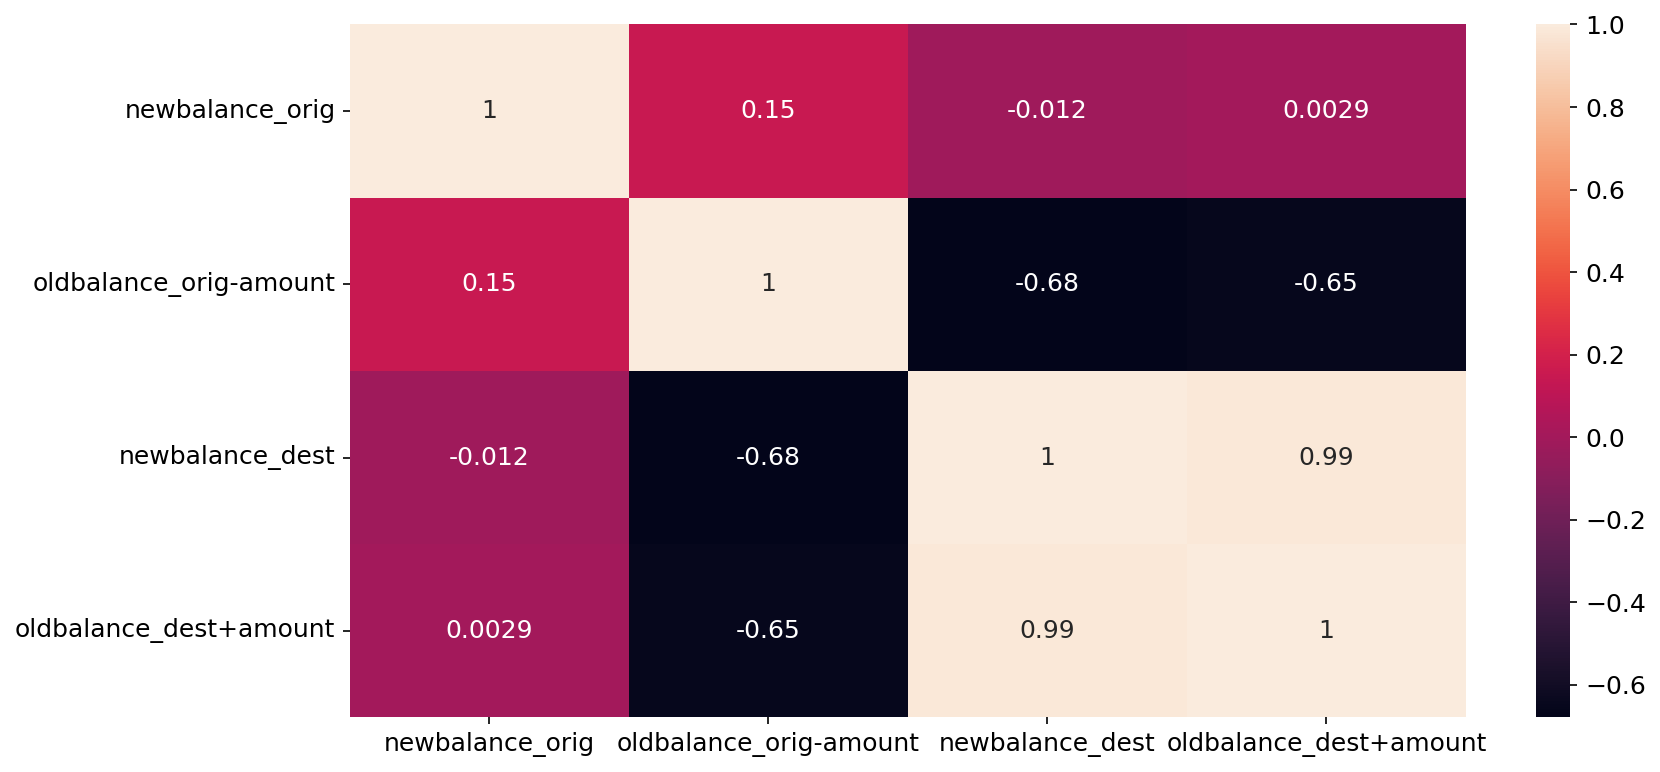

In [155]:
sns.heatmap(transactions_aux[['newbalance_orig', 'oldbalance_orig-amount', 'newbalance_dest',
       'oldbalance_dest+amount']].select_dtypes(np.number).corr(), annot=True)
plt.show()

As we thought: 
- newbalance_dest shares a 0.99 correlation with oldbalance_dest+amount
- newbalance_orig shares a 0.99 correlation with olbalance_orig-amount

We could be tempted to remove it then, but that could hurt the model: there are some exceptions (and that's why our correlation is not one). These exceptions have a way higher frequency of fraud transfers than the average one. If we remove the column, we would be deleting this information. I will later compare two models with them and without them. That's why I won't drop any column for now.

In [156]:
transactions 
# question: should I use time series because of the 'step' column?

,step,type,amount,oldbalance_orig,newbalance_orig,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud
3,228,cash_out,458069.49,350.0,0.0,0.00,458069.49,0,0
6,164,cash_out,359137.52,0.0,0.0,6248009.29,6607146.80,0,0
7,281,cash_out,155950.22,42153.0,0.0,10774513.91,10930464.13,0,0
8,236,transfer,165208.33,0.0,0.0,260994.14,426202.47,0,0
9,237,cash_out,170997.34,0.0,0.0,718671.66,889669.00,0,0
...,...,...,...,...,...,...,...,...,...
6362605,322,transfer,1081191.45,30614.0,0.0,0.00,1081191.45,0,0
6362607,376,cash_out,508719.80,0.0,0.0,550935.04,1059654.84,0,0
6362609,279,cash_out,63935.62,35261.0,0.0,30502.20,94437.81,0,0
6362611,156,cash_out,173639.42,0.0,0.0,569239.81,742879.23,0,0


# Analysis

## X,Y & Train,Test split

In [157]:
X = transactions.drop(['is_fraud'],axis=1)
y = transactions['is_fraud']

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

In [20]:
X_ready, X_ready_test = scale_encode(X_train,X_test)

In [ ]:
#X_ready.head()

# Testing models

## All columns, Umbalanced data

In [ ]:
%%time
confusions, recalls = pipeline_models(X_ready,y_train,X_ready_test,y_test,epochs=10)

In [ ]:
for model_name in confusions.keys():
    print(model_name)
    print(confusions[model_name])
    print(recalls[model_name],'\n')

As we can see the logistic regressor and deep learning are awful because it basically predicts almost every transaction as a not fraudulent. The others have a recall of 40-70% which are not awful, but we might be able to do better. Let's see how balancing our data changes the scores:

## All columns, balanced data

In [161]:
X_ready_oversample, y_train_oversample, X_ready_test  = scale_encode(X_train,X_test,balance=True,y_train = y_train)

In [163]:
%%time
confusions_over, recalls_over, precisions_over, accuracies_over, f1s_over = pipeline_models(X_ready_oversample,y_train_oversample,X_ready_test,y_test,epochs=10)

for model_name in confusions_over.keys():
    print(model_name)
    print(confusions_over[model_name])
    print('Accuracy: ', accuracies_over[model_name])
    print('Recall: ', recalls_over[model_name])
    print('Precision: ', precisions_over[model_name])
    print('F1 Score: ', f1s_over[model_name],'\n')

Epoch 1/10 Deep Learning...   
138110/138110 [==============================] - 239s 2ms/step - loss: 0.0721 - accuracy: 0.9726 - precision: 0.9694 - recall: 0.9759
Epoch 2/10
138110/138110 [==============================] - 237s 2ms/step - loss: 0.0444 - accuracy: 0.9838 - precision: 0.9796 - recall: 0.9883
Epoch 3/10
138110/138110 [==============================] - 237s 2ms/step - loss: 0.0397 - accuracy: 0.9855 - precision: 0.9817 - recall: 0.9894
Epoch 4/10
138110/138110 [==============================] - 238s 2ms/step - loss: 0.0369 - accuracy: 0.9866 - precision: 0.9832 - recall: 0.9902
Epoch 5/10
138110/138110 [==============================] - 238s 2ms/step - loss: 0.0350 - accuracy: 0.9874 - precision: 0.9840 - recall: 0.9910
Epoch 6/10
138110/138110 [==============================] - 237s 2ms/step - loss: 0.0326 - accuracy: 0.9883 - precision: 0.9852 - recall: 0.9915
Epoch 7/10
138110/138110 [==============================] - 238s 2ms/step - loss: 0.0316 - accuracy: 0.9887 - 

## Model dropping correlated columns, balanced data

We have seen that the best results were achivied by balancing our data. Let's now see how the models would work if we dropped the correlated columns we discussed in the previous section (newbalance_orig and newbalance_dest).

In [165]:
%%time
confusions_over, recalls_over, precisions_over, accuracies_over, f1s_over = pipeline_models(X_ready_oversample.drop(['newbalance_orig','newbalance_dest'],axis=1),y_train_oversample,X_ready_test.drop(['newbalance_orig','newbalance_dest'],axis=1),y_test,epochs=10)

for model_name in confusions_over.keys():
    print(model_name)
    print(confusions_over[model_name])
    print('Accuracy: ', accuracies_over[model_name])
    print('Recall: ', recalls_over[model_name])
    print('Precision: ', precisions_over[model_name])
    print('F1 Score: ', f1s_over[model_name],'\n')

Epoch 1/10 Deep Learning...   
138110/138110 [==============================] - 211s 2ms/step - loss: 0.0896 - accuracy: 0.9650 - precision: 0.9593 - recall: 0.9712
Epoch 2/10
138110/138110 [==============================] - 209s 2ms/step - loss: 0.0581 - accuracy: 0.9787 - precision: 0.9723 - recall: 0.9854
Epoch 3/10
138110/138110 [==============================] - 209s 2ms/step - loss: 0.0506 - accuracy: 0.9815 - precision: 0.9756 - recall: 0.9877
Epoch 4/10
138110/138110 [==============================] - 209s 2ms/step - loss: 0.0461 - accuracy: 0.9833 - precision: 0.9775 - recall: 0.9893
Epoch 5/10
138110/138110 [==============================] - 209s 2ms/step - loss: 0.0432 - accuracy: 0.9845 - precision: 0.9789 - recall: 0.9904
Epoch 6/10
138110/138110 [==============================] - 209s 2ms/step - loss: 0.0408 - accuracy: 0.9853 - precision: 0.9798 - recall: 0.9911
Epoch 7/10
138110/138110 [==============================] - 209s 2ms/step - loss: 0.0397 - accuracy: 0.9860 - 

As we expected, all of the models are suffering from the absence of the newbalance columns. To make sure that this is indeed the case and not a coincidence, I'll do manual crossvalidation.

## Cross-validation on deep learning

We don't need to randomize the columns since they're already randomized. Let's loop through different folds and check how the model changes parameters change.

In [166]:
n_folds = 5
# let's compute the number of rows per fold:
delta_fold = math.floor(len(X_ready_oversample)/n_folds)

In [98]:
X_ready_oversample

,step,amount,oldbalance_orig,newbalance_orig,oldbalance_dest,newbalance_dest,is_flagged_fraud,type_transfer
0,0.047170,0.025448,0.041045,0.0,0.000000,0.000000,0.0,1.0
1,0.419137,0.071182,0.114809,0.0,0.000000,0.018475,0.0,0.0
2,0.296496,0.001014,0.001635,0.0,0.000000,0.000000,0.0,1.0
3,0.545822,0.000099,0.000160,0.0,0.000000,0.000026,0.0,0.0
4,0.886792,0.000547,0.000882,0.0,0.000000,0.000000,0.0,1.0
...,...,...,...,...,...,...,...,...
4419369,0.314016,0.003096,0.003300,0.0,0.000974,0.001777,0.0,0.0
4419370,0.613208,0.000413,0.000666,0.0,0.000379,0.000486,0.0,0.0
4419371,0.274933,0.000849,0.000543,0.0,0.000000,0.000220,0.0,0.0
4419372,0.497305,0.019717,0.031802,0.0,0.000000,0.000000,0.0,1.0


### Cross validation on "All columns"

In [119]:
%%time
epochs = 5
confusions = []
recalls = []
f1s = []
accuracies = []
precisions = []
for i in range(n_folds):
    # Creating a fold for this iteration
    if i == 0:
        # I use i = 0 as an exception in order not to lose the row = 0
        xfold_test = X_ready_oversample.loc[0:(i+1)*delta_fold]
        yfold_test = y_train_oversample.loc[0:(i+1)*delta_fold]
        xfold_train = X_ready_oversample.loc[(i+1)*delta_fold+1:delta_fold*n_folds]
        yfold_train = y_train_oversample.loc[(i+1)*delta_fold+1:delta_fold*n_folds]
    else:
        xfold_test = X_ready_oversample.loc[i*delta_fold+1:(i+1)*delta_fold]
        yfold_test = y_train_oversample.loc[i*delta_fold+1:(i+1)*delta_fold]
        xfold_train = X_ready_oversample.loc[np.r_[0:i*delta_fold+1,(i+1)*delta_fold:delta_fold*n_folds]]
        yfold_train = y_train_oversample.loc[np.r_[0:i*delta_fold+1,(i+1)*delta_fold:delta_fold*n_folds]]
        
    # Creating and testing a model for this fold:
    model = define_deeplearning()
    model.fit(xfold_train, yfold_train, epochs=epochs)
    y_pred = model.predict(xfold_test)
    for i in range(len(y_pred)):
        if y_pred[i] >= 0.5:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    
    # Saving results
    confusions.append(confusion_matrix(yfold_test, y_pred))
    recalls.append(recall_score(yfold_test,y_pred))
    f1s.append(f1_score(yfold_test,y_pred))
    precisions.append(precision_score(yfold_test,y_pred))
    accuracies.append(accuracy_score(yfold_test,y_pred))

Epoch 1/5
110485/110485 [==============================] - 328s 3ms/step - loss: 0.0760 - accuracy: 0.9709 - precision: 0.9675 - recall: 0.9745
Epoch 2/5
110485/110485 [==============================] - 340s 3ms/step - loss: 0.0458 - accuracy: 0.9837 - precision: 0.9794 - recall: 0.9881
Epoch 3/5
110485/110485 [==============================] - 341s 3ms/step - loss: 0.0413 - accuracy: 0.9852 - precision: 0.9811 - recall: 0.9894
Epoch 4/5
110485/110485 [==============================] - 340s 3ms/step - loss: 0.0385 - accuracy: 0.9863 - precision: 0.9824 - recall: 0.9904
Epoch 5/5
27622/27622 [==============================] - 31s 1ms/step
Epoch 1/5
110485/110485 [==============================] - 331s 3ms/step - loss: 0.0757 - accuracy: 0.9710 - precision: 0.9673 - recall: 0.9749
Epoch 2/5
110485/110485 [==============================] - 322s 3ms/step - loss: 0.0469 - accuracy: 0.9829 - precision: 0.9780 - recall: 0.9880
Epoch 3/5
110485/110485 [==============================] - 320s 3m

In [138]:
for i in range(len(confusions)):
    print('--- Fold %i ---' %(i+1))
    print('Accuracy: %.3f' %accuracies[i])
    print('Precision: %.3f' %precisions[i])
    print('Recall: %.3f' %recalls[i])
    print('F1 Score: %.3f \n' %f1s[i])

print('---- Mean ----')
print('Accuracy: %.3f' %np.mean(accuracies))
print('Precision: %.3f' %np.mean(precisions))
print('Recall: %.3f' %np.mean(recalls))
print('F1 Score: %.3f \n' %np.mean(f1s))

--- Fold 1 ---
Accuracy: 0.990
Precision: 0.983
Recall: 0.996
F1 Score: 0.990 

--- Fold 2 ---
Accuracy: 0.991
Precision: 0.995
Recall: 0.986
F1 Score: 0.991 

--- Fold 3 ---
Accuracy: 0.985
Precision: 0.983
Recall: 0.987
F1 Score: 0.985 

--- Fold 4 ---
Accuracy: 0.983
Precision: 0.969
Recall: 0.998
F1 Score: 0.983 

--- Fold 5 ---
Accuracy: 0.990
Precision: 0.989
Recall: 0.991
F1 Score: 0.990 

---- Mean ----
Accuracy: 0.988
Precision: 0.984
Recall: 0.992
F1 Score: 0.988 



### Cross validation on "without newbalance"

In [131]:
X_oversample_nonew = X_ready_oversample.drop(['newbalance_orig','newbalance_dest'],axis=1)
X_oversample_nonew

,step,amount,oldbalance_orig,oldbalance_dest,is_flagged_fraud,type_transfer
0,0.047170,0.025448,0.041045,0.000000,0.0,1.0
1,0.419137,0.071182,0.114809,0.000000,0.0,0.0
2,0.296496,0.001014,0.001635,0.000000,0.0,1.0
3,0.545822,0.000099,0.000160,0.000000,0.0,0.0
4,0.886792,0.000547,0.000882,0.000000,0.0,1.0
...,...,...,...,...,...,...
4419369,0.314016,0.003096,0.003300,0.000974,0.0,0.0
4419370,0.613208,0.000413,0.000666,0.000379,0.0,0.0
4419371,0.274933,0.000849,0.000543,0.000000,0.0,0.0
4419372,0.497305,0.019717,0.031802,0.000000,0.0,1.0


In [134]:
%%time
epochs = 5
confusions_nonew = []
recalls_nonew = []
f1s_nonew = []
accuracies_nonew = []
precisions_nonew = []

for i in range(n_folds):
    # Creating a fold for this iteration
    if i == 0:
        # I use i = 0 as an exception in order not to lose the row = 0
        xfold_test = X_oversample_nonew.loc[0:(i+1)*delta_fold]
        yfold_test = y_train_oversample.loc[0:(i+1)*delta_fold]
        xfold_train = X_oversample_nonew.loc[(i+1)*delta_fold+1:delta_fold*n_folds]
        yfold_train = y_train_oversample.loc[(i+1)*delta_fold+1:delta_fold*n_folds]
    else:
        xfold_test = X_oversample_nonew.loc[i*delta_fold+1:(i+1)*delta_fold]
        yfold_test = y_train_oversample.loc[i*delta_fold+1:(i+1)*delta_fold]
        xfold_train = X_oversample_nonew.loc[np.r_[0:i*delta_fold+1,(i+1)*delta_fold:delta_fold*n_folds]]
        yfold_train = y_train_oversample.loc[np.r_[0:i*delta_fold+1,(i+1)*delta_fold:delta_fold*n_folds]]
        
    # Creating and testing a model for this fold:
    model = define_deeplearning()
    model.fit(xfold_train, yfold_train, epochs=epochs)
    y_pred = model.predict(xfold_test)
    for i in range(len(y_pred)):
        if y_pred[i] >= 0.5:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    
    # Saving results
    confusions_nonew.append(confusion_matrix(yfold_test, y_pred))
    recalls_nonew.append(recall_score(yfold_test,y_pred))
    f1s_nonew.append(f1_score(yfold_test,y_pred))
    precisions_nonew.append(precision_score(yfold_test,y_pred))
    accuracies_nonew.append(accuracy_score(yfold_test,y_pred))

Epoch 1/5
110485/110485 [==============================] - 238s 2ms/step - loss: 0.0935 - accuracy: 0.9633 - precision: 0.9565 - recall: 0.9708
Epoch 2/5
110485/110485 [==============================] - 238s 2ms/step - loss: 0.0608 - accuracy: 0.9778 - precision: 0.9705 - recall: 0.9856
Epoch 3/5
110485/110485 [==============================] - 241s 2ms/step - loss: 0.0533 - accuracy: 0.9806 - precision: 0.9739 - recall: 0.9876
Epoch 4/5
110485/110485 [==============================] - 237s 2ms/step - loss: 0.0488 - accuracy: 0.9823 - precision: 0.9759 - recall: 0.9891
Epoch 5/5
27622/27622 [==============================] - 25s 915us/step
Epoch 1/5
110485/110485 [==============================] - 204s 2ms/step - loss: 0.0956 - accuracy: 0.9622 - precision: 0.9563 - recall: 0.9687
Epoch 2/5
110485/110485 [==============================] - 205s 2ms/step - loss: 0.0601 - accuracy: 0.9778 - precision: 0.9708 - recall: 0.9852
Epoch 3/5
110485/110485 [==============================] - 206s 

In [139]:
for i in range(len(confusions_nonew)):
    print('--- Fold %i ---' %(i+1))
    print('Accuracy: %.3f' %accuracies_nonew[i])
    print('Precision: %.3f' %precisions_nonew[i])
    print('Recall: %.3f' %recalls_nonew[i])
    print('F1 Score: %.3f \n' %f1s_nonew[i])
    
print('---- Mean ----')
print('Accuracy: %.3f' %np.mean(accuracies_nonew))
print('Precision: %.3f' %np.mean(precisions_nonew))
print('Recall: %.3f' %np.mean(recalls_nonew))
print('F1 Score: %.3f \n' %np.mean(f1s_nonew))

--- Fold 1 ---
Accuracy: 0.985
Precision: 0.977
Recall: 0.993
F1 Score: 0.985 

--- Fold 2 ---
Accuracy: 0.987
Precision: 0.980
Recall: 0.995
F1 Score: 0.987 

--- Fold 3 ---
Accuracy: 0.985
Precision: 0.976
Recall: 0.994
F1 Score: 0.985 

--- Fold 4 ---
Accuracy: 0.979
Precision: 0.963
Recall: 0.997
F1 Score: 0.980 

--- Fold 5 ---
Accuracy: 0.983
Precision: 0.982
Recall: 0.985
F1 Score: 0.983 

---- Mean ----
Accuracy: 0.984
Precision: 0.975
Recall: 0.993
F1 Score: 0.984 



I'm getting higher values for my all-columns model than the other, as we expected, tho the difference is not that big, except on the precision accuracy that its 0.14 points superior.

|           | 'All Columns' | 'Without newbalance' |
|:---------:|:-------------:|:--------------------:|
|  Accuracy |     0.988     |         0.984        |
| Precision |     0.989     |         0.975        |
|   Recall  |     0.993     |         0.993        |
|  F1 Score |     0.988     |         0.984        |

## Hyperparameter search

We have really nice results for some of the simplest models (LR, KNN, Tree and Forest). Let's try to play with their parameters to find an optimal value and see which results do these new models return. 

### Logistic regression

In [192]:
'''%%time
penalty_choices = ['l1','l2']
solver_choices = ['lbfgs', 'saga']

grid = {'penalty': penalty_choices,
'solver': solver_choices}

# Instantiate the grid search model object
# estimator -> model to optimize
model = LogisticRegression(multi_class='ovr', n_jobs = 10)
# param_grid -> state the dictionary of parameters to optimize
# cv = 5 -> number of cross validation folds <------ CV is REALLY important in grid search. Why?
grid_search = GridSearchCV(estimator = model, param_grid = grid, cv = 5)
 
# Fit the grid search to the data
grid_search.fit(X_ready_oversample, y_train_oversample)'''

"%%time\npenalty_choices = ['l1','l2']\nsolver_choices = ['lbfgs', 'saga']\n\ngrid = {'penalty': penalty_choices,\n'solver': solver_choices}\n\n# Instantiate the grid search model object\n# estimator -> model to optimize\nmodel = LogisticRegression(multi_class='ovr', n_jobs = 10)\n# param_grid -> state the dictionary of parameters to optimize\n# cv = 5 -> number of cross validation folds <------ CV is REALLY important in grid search. Why?\ngrid_search = GridSearchCV(estimator = model, param_grid = grid, cv = 5)\n \n# Fit the grid search to the data\ngrid_search.fit(X_ready_oversample, y_train_oversample)"

In [193]:
'''# and the winner is...
print(grid_search.best_params_)
# in grid search you are more likely to get really good results in your training set, even with CV
print(grid_search.best_score_)'''

'# and the winner is...\nprint(grid_search.best_params_)\n# in grid search you are more likely to get really good results in your training set, even with CV\nprint(grid_search.best_score_)'

### Tree Model

In [179]:
%%time
max_depth_choices= [None,2,8]
min_samples_split_choices = [2,4,8]
min_samples_leaf_choices = [2,4,8]

grid = {'max_depth': max_depth_choices,
'min_samples_split': min_samples_split_choices,
'min_samples_leaf': min_samples_leaf_choices}

# Instantiate the grid search model object
# estimator -> model to optimize
model = DecisionTreeClassifier()
# param_grid -> state the dictionary of parameters to optimize
# cv = 5 -> number of cross validation folds <------ CV is REALLY important in grid search. Why?
grid_search = GridSearchCV(estimator = model, param_grid = grid, cv = 5)

# Fit the grid search to the data
grid_search.fit(X_ready_oversample, y_train_oversample)


CPU times: user 39min 13s, sys: 29.2 s, total: 39min 42s
Wall time: 39min 50s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [None, 2, 8],
                         'min_samples_leaf': [2, 4, 8],
                         'min_samples_split': [2, 4, 8]})

In [183]:
# and the winner is...
print(grid_search.best_params_)
# in grid search you are more likely to get really good results in your training set, even with CV
print(grid_search.best_score_)

{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 8}
0.9997981669403433


### Random Forest

In [196]:
%%time
max_depth_choices= [None,8]
min_samples_split_choices = [2,8]
min_samples_leaf_choices = [2,8]

grid = {'max_depth': max_depth_choices,
'min_samples_split': min_samples_split_choices,
'min_samples_leaf': min_samples_leaf_choices}

# Instantiate the grid search model object
# estimator -> model to optimize
model = RandomForestClassifier(n_jobs = 10)
# param_grid -> state the dictionary of parameters to optimize
# cv = 5 -> number of cross validation folds <------ CV is REALLY important in grid search. Why?
grid_search = GridSearchCV(estimator = model, param_grid = grid, cv = 5)

# Fit the grid search to the data
grid_search.fit(X_ready_oversample, y_train_oversample)

CPU times: user 34min 1s, sys: 37 s, total: 34min 38s
Wall time: 1h 21min 9s


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=10),
             param_grid={'max_depth': [None, 8], 'min_samples_leaf': [2, 8],
                         'min_samples_split': [2, 8]})

In [197]:
# and the winner is...
print(grid_search.best_params_)
# in grid search you are more likely to get really good results in your training set, even with CV
print(grid_search.best_score_)

{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
0.9999158274699257


### Deep learning...?

In [ ]:
layer_elements = [64,128,256]
layers = [3,6]

In [ ]:
model0 = tf.keras.Sequential([
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.Dense(256, activation='relu'),
tf.keras.layers.Dense(256, activation='relu'),
tf.keras.layers.Dense(1, activation='sigmoid')
])

model1 = tf.keras.Sequential([
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.Dense(1, activation='sigmoid')
])

model2 = tf.keras.Sequential([
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dense(256, activation='relu'),
tf.keras.layers.Dense(256, activation='relu'),
tf.keras.layers.Dense(1, activation='sigmoid')
])

model3 = tf.keras.Sequential([
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dense(128, activation='relu'),
tf.keras.layers.Dense(256, activation='relu'),
tf.keras.layers.Dense(1, activation='sigmoid')
])

model_pipeline = [model0, model1, model2,model3]
model_names = ['Deep Learning 0','Deep Learning 1', 'Deep Learning 2', 'Deep Learning 3']
recalls = {}
confusions = {}
f1s = {}
accuracies = {}
precisions = {}
 
for model,model_name in zip(model_pipeline, model_names):
    print('Working on '+model_name+'...')
    
            
    model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
    ]
    )
 
    model.fit(X_ready_oversample, y_train_oversample, epochs=5)
    y_pred = model.predict(X_ready_test)
        
    for i in range(len(y_pred)):
        if y_pred[i] >= 0.5:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    
    # Saving results
    confusions[model_name] = confusion_matrix(y_test, y_pred)
    recalls[model_name] = recall_score(y_test,y_pred)
    f1s[model_name] = f1_score(y_test,y_pred)
    accuracies[model_name] = accuracy_score(y_test,y_pred)
    precisions[model_name] = precision_score(y_test,y_pred)

        
print('All models completed.',end='\r')

Working on Deep Learning 0...
Epoch 1/5
138110/138110 [==============================] - 250s 2ms/step - loss: 0.0735 - accuracy: 0.9720 - precision: 0.9691 - recall: 0.9750
Epoch 2/5
138110/138110 [==============================] - 290s 2ms/step - loss: 0.0450 - accuracy: 0.9838 - precision: 0.9799 - recall: 0.9878
Epoch 3/5
138110/138110 [==============================] - 244s 2ms/step - loss: 0.0398 - accuracy: 0.9855 - precision: 0.9821 - recall: 0.9890
Epoch 4/5
138110/138110 [==============================] - 207s 1ms/step - loss: 0.0368 - accuracy: 0.9864 - precision: 0.9830 - recall: 0.9900
Epoch 5/5
17316/17316 [==============================] - 14s 784us/step
Working on Deep Learning 1...
Epoch 1/5
 53730/138110 [==========>...................] - ETA: 1:32 - loss: 0.1026 - accuracy: 0.9599 - precision: 0.9602 - recall: 0.9595

In [ ]:
for i in range(len(confusions)):
    print('--- Fold %i ---' %(i+1))
    print('Accuracy: %.3f' %accuracies[i])
    print('Precision: %.3f' %precisions[i])
    print('Recall: %.3f' %recalls[i])
    print('F1 Score: %.3f \n' %f1s[i])

print('---- Mean ----')
print('Accuracy: %.3f' %np.mean(accuracies))
print('Precision: %.3f' %np.mean(precisions))
print('Recall: %.3f' %np.mean(recalls))
print('F1 Score: %.3f \n' %np.mean(f1s))

## Evaluating different models

We need a criteria in order to choose a model. This depends on the bussiness objectives, but we'll start with a solid one: saving money for both the company and the customers. 

If we call $M$ the lost money by our model, then we have that
$$ M = \hat{m}_1 \times CF_{01} + \hat{m}_0 \times CF_{10}$$   
where $\hat{m}$ is the mean amount for yes/non fraudulent transactions, and $CF_{ij}$ refers to the element of the confusion matrix with row $i$ and column $j$. 

In [213]:
m1 = category_1.amount.mean()
m0 = category_0.amount.mean()
# Deep learning
print('In the DL model the bank would lose %.1f.' %(m0*3757+m1*17))
# Random Forest
print('The RF model the bank would lose %.1f.' %(m0*297+m1*58))

In the DL model the bank would lose 13.0.
The RF model the bank would lose 1.9.


If we were to use one model, it's clear that the random forest would give us a superior model (we would save more money). But can we use several models? Can we try another model to see the diffence between $CF(0,1)$ and $CF(1,1)$?

In [ ]:
# Maybe try to balance in a softer way and see if the deep learning model works better than the random forest

In [ ]:
# I need to evaluate 

In [198]:
# I want to make a model out of the predicted 1 from the deep model, to see if there's a chance a new model can learn to distinguish them with ease (who knows?)

In [174]:
def snake_case(columns):
    # Input: list of strings (name of columns)
    # Output: the same list converted to snake_case
    
    # Transforming columns to a list of strings (if it isn't already)
    columns = list(columns)
    
    for i in range(len(columns)):
        
        # Removing boundary spaces
        columns[i] = columns[i].strip() 
        
        # Converting 'xX' to 'x_X'
        columns[i] = re.sub(r'([a-z])([A-Z])',r'\1_\2', columns[i])
        # Converting 'x x' to 'x_x'
        columns[i] = re.sub(r'([a-z])[\s]+([A-Za-z])',r'\1_\2', columns[i])
                            
        # Transforming to lowercase
        columns[i] = columns[i].lower()
        
        # Transforming 'org' to 'orig' to standarize columns
        columns[i] = re.sub('org','orig', columns[i])

    return columns

def undo_snake_case(columns):
    # Input: list of strings
    # Output: the same list converted to normal text
    
    # Transforming columns to a list of strings (if it isn't already)
    columns = list(columns)
    
    for i in range(len(columns)):
        
        # Removing boundary spaces
        columns[i] = columns[i].strip() 
        
        # Converting 'x_X' to 'x_X'
        columns[i] = re.sub(r'(\w)_(\w)',r'\1 \2', columns[i])
   
        # Transforming to lowercase
        columns[i] = columns[i].capitalize()

    return columns

def cute_graph(title=None, xlabel = None, ylabel = None, xticklabels = None):
    # Handy function that changes several parameters of the plot 
    # to make it look a bit better. 
    
    sns.despine(bottom = True, left = True)
    ax.bar_label(ax.containers[0], fmt='%.3g%%')
    plt.tick_params(labelleft=False, left=False)
    
    if title != None:
        if len(title) == 2:
            plt.title(title[0],fontsize=title[1])
        else:
            plt.title(title)
            
    if xlabel != None:
        if len(xlabel) == 2:
            plt.xlabel(xlabel[0],fontsize=xlabel[1])
        else:
            plt.xlabel(xlabel)
                   
    if ylabel != None:
        if len(ylabel) == 2:
            plt.ylabel(ylabel[0],fontsize=ylabel[1])
        else:
            plt.ylabel(ylabel)
    
    if xticklabels != None:
        ax.set(xticklabels=xticklabels)
        
    ax.xaxis.set_ticks_position('none') 
    return

def pipeline_models(X_ready,y_train,X_ready_test,y_test,epochs):
    # Entry: X_ready = X_train, y_train, X_ready_test, y_test, number of epochs for deep learning
    # Output: scores and confusions matrix for five models (deep learning, logistic regression,
    # knn, tree and random forest)
    
    # defining models
    model1 = LogisticRegression(solver='lbfgs', multi_class='ovr', n_jobs = 10)
    model2 = neighbors.KNeighborsClassifier(n_jobs = 10)
    model3 = DecisionTreeClassifier(max_depth=None)
    model4 = RandomForestClassifier(max_depth=None, max_samples=0.8, n_jobs = 10)
    model0 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # initializing variables
    model_pipeline = [model0, model1, model2, model3, model4]
    model_names = ['Deep Learning','Logistic Regressor', 'KNN Classifier', 'Tree Classifier', 'Random Forest']
    recalls = {}
    confusions = {}
    f1s = {}
    accuracies = {}
    precisions = {}

    # pipeline loop
    for model, model_name in zip(model_pipeline, model_names):
        print(' '*30 ,end='\r')
        print('Working on '+model_name+'...' ,end='\r')
        
        if model_name != 'Deep Learning':
            model.fit(X_ready,y_train)
            y_pred = model.predict(X_ready_test)
            
        else:
            model.compile(
            loss=tf.keras.losses.binary_crossentropy,
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
            ]
            )
            model.fit(X_ready, y_train, epochs=epochs)
            y_pred = model.predict(X_ready_test)
            
            for i in range(len(y_pred)):
                if y_pred[i] >= 0.5:
                    y_pred[i] = 1
                else:
                    y_pred[i] = 0
        
        # Saving results
        confusions[model_name] = confusion_matrix(y_test, y_pred)
        recalls[model_name] = recall_score(y_test,y_pred)
        f1s[model_name] = f1_score(y_test,y_pred)
        accuracies[model_name] = accuracy_score(y_test,y_pred)
        precisions[model_name] = precision_score(y_test,y_pred)

        
    print('All models completed.',end='\r')
    return confusions, recalls, precisions, accuracies, f1s

def round_up(x):
    if x%1 == 0:
        return int(x)
    else:
        return math.floor(x)
    
def define_deeplearning():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
    ]
    )
    
    return model

In [54]:
5.5%1

0.5

In [3]:
def scale_encode(X_train,X_test,balance=False,y_train = None):
    # INPUT: X_train and X_test
    # OUTPUT: X_train and X_test where its numerical columns are minmaxscaled
    # and its categorical columns are encoded.
    
    # X_train scale & encode
    X_num = X_train.select_dtypes(np.number)

    transformer = MinMaxScaler().fit(X_num)
    X_normalized = transformer.transform(X_num)
    X_normalized = pd.DataFrame(X_normalized, columns=X_num.columns)
    X_normalized.head

    X_cat = X_train.select_dtypes(object)
    encoder = OneHotEncoder(handle_unknown='error',drop='first').fit(X_cat)
    encoded = encoder.transform(X_cat).toarray()
    onehot_encoded = pd.DataFrame(encoded,columns=encoder.get_feature_names_out(X_cat.columns))

    X_ready = pd.concat([X_normalized,onehot_encoded],axis=1)

    # X_test scale & encode
    X_num_test = X_test.select_dtypes(np.number)
    X_normalized_test = transformer.transform(X_num_test)
    X_normalized_test = pd.DataFrame(X_normalized_test, columns=X_num_test.columns)

    X_cat_test = X_test.select_dtypes(object)
    encoded = encoder.transform(X_cat_test).toarray()
    onehot_encoded_test = pd.DataFrame(encoded,columns=encoder.get_feature_names_out(X_cat_test.columns))

    X_ready_test = pd.concat([X_normalized_test,onehot_encoded_test],axis=1)
    
    if balance == True:
        # Separating categories
        category_0 = X_ready[y_train==0].copy()
        category_1 = X_ready[y_train==1].copy()

        # Overesampling
        category_1_oversample = resample(category_1,
        replace=True,
        n_samples = len(category_0))

        # Creating oversample Y
        category_0['target'] = 0
        category_1_oversample['target'] = 1

        # Concatenating back and reordering
        data_oversampled = pd.concat([category_0, category_1_oversample], axis=0)
        data_oversampled = data_oversampled.sample(frac=1).reset_index(drop=True) #randomizing rows
        X_ready_oversample = data_oversampled.drop('target',axis=1)
        y_train_oversample = data_oversampled['target']
        
        return X_ready_oversample, y_train_oversample, X_ready_test
        
    
    return X_ready, X_ready_test

In [ ]:
math.ceil(5.1)

In [ ]:
'''values = transactions_aux['newbalance_dest']/transactions_aux['oldbalance_dest+amount']
condition = (abs(values)<0.95)
transactions_aux[condition].is_fraud.value_counts()[1]/transactions_aux[condition].is_fraud.value_counts()[0]*100

transactions.loc[transactions['type']=='transfer','is_fraud'].value_counts()[1]/transactions.loc[transactions['type']=='transfer','is_fraud'].value_counts()[0]*100

# If the origen account pays more than it has, he will be in debt.
# transactions['in_debt_orig'] = transactions['oldbalance_orig']<transactions['amount']

# After some thinking, I won't do this for the origen account, because this information is already contained 
# within the columns oldbalance_orig and amount, and I'm not dropping neither of those.

# If the destination account recivies a transaction > 0 and the newbalance is not the sum we saw, it was in debt.
# I have to do save this because by dropping newbalance_dest I'll be leaving this information behind. 
transactions['in_debt_dest'] = (((transactions['newbalance_dest']-transactions['oldbalance_dest'])/transactions['amount'] < 0.9)|((transactions['newbalance_dest']-transactions['oldbalance_dest'])/transactions['amount'] > 1.1))&(transactions['amount']>0)&(transactions['name_dest']!='M')

'''

In [ ]:
# Separating categories
category_0 = X_ready[y_train==0].copy()
category_1 = X_ready[y_train==1].copy()

# Overesampling
category_1_oversample = resample(category_1,
replace=True,
n_samples = len(category_0))

# Creating oversample Y
category_0['target'] = 0
category_1_oversample['target'] = 1

# Concatenating back and creating target (do I need to reorder?)
data_oversampled = pd.concat([category_0, category_1_oversample], axis=0)
data_oversampled = data_oversampled.sample(frac=1).reset_index(drop=True) #randomizing rows
X_ready_oversample = data_oversampled.drop('target',axis=1)
y_train_oversample = data_oversampled['target']